# Load CholecOrgans Dataset

Minimal example to load and display examples from the CholecOrgans dataset (Liver, Gallbladder, Hepatocystic Triangle).

In [1]:
import sys
sys.path.insert(0, '/shared_data0/weiqiuy/llm_cholec_organ/src')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from endopoint.datasets import build_dataset
import numpy as np

In [2]:
# Load the CholecOrgans dataset
dataset = build_dataset(
    "cholec_organs",
    data_dir="/shared_data0/weiqiuy/real_drs/data/abdomen_exlib",
    video_globs='public',  # Can be 'public' or 'private'
    train_ratio=0.8,
    gen_seed=56,  # Default seed for train/test split
    train_val_seed=0,  # Default seed for train/val split
    image_height=384,
    image_width=640
)

print(f"Dataset: {dataset.dataset_tag}")
print(f"Version: {dataset.version}")
print(f"Train examples: {dataset.total('train')}")
print(f"Validation examples: {dataset.total('validation')}")
print(f"Test examples: {dataset.total('test')}")
print(f"\nOrgan classes: {dataset.id2label}")
print(f"Target image size: {dataset.recommended_canvas}")

Indexing training videos...


  Train videos: 100%|██████████| 96/96 [00:00<00:00, 543.29it/s]


Indexing test videos...


  Test videos: 100%|██████████| 25/25 [00:00<00:00, 542.38it/s]


Building examples list...


  Checking files: 100%|██████████| 1015/1015 [00:00<00:00, 4148.01it/s]

CholecOrgans dataset indexed:
  Total examples: 1015
  Train: 716 examples
  Validation: 80 examples
  Test: 219 examples
Dataset: cholec_organs
Version: local
Train examples: 716
Validation examples: 80
Test examples: 219

Organ classes: {0: 'Background', 1: 'Liver', 2: 'Gallbladder', 3: 'Hepatocystic Triangle'}
Target image size: (384, 640)


## Load and Display a Single Example

In [3]:
# Load a single example from training set
example_idx = 0
example = dataset.get_example("train", example_idx)

image = example['image']  # PIL Image
organ_label = example['organ_label']  # PIL Image with organ labels
filename = example['filename']

print(f"Filename: {filename}")
print(f"Image size: {image.size}")
print(f"Label size: {organ_label.size}")

Filename: M2CCAI2016_video88_003.png
Image size: (640, 384)
Label size: (640, 384)


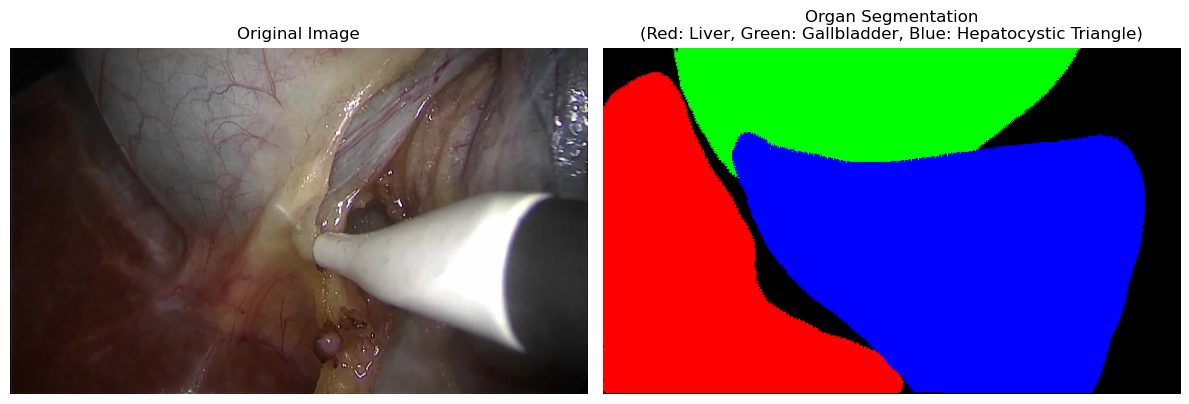

In [4]:
# Display the image and organ segmentation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Convert label to numpy for visualization
label_np = np.array(organ_label)

# Create a colored visualization of the labels
# 0: Background (black), 1: Liver (red), 2: Gallbladder (green), 3: Hepatocystic Triangle (blue)
colored_label = np.zeros((*label_np.shape, 3), dtype=np.uint8)
colored_label[label_np == 1] = [255, 0, 0]     # Liver - red
colored_label[label_np == 2] = [0, 255, 0]     # Gallbladder - green
colored_label[label_np == 3] = [0, 0, 255]     # Hepatocystic Triangle - blue

axes[1].imshow(colored_label)
axes[1].set_title('Organ Segmentation\n(Red: Liver, Green: Gallbladder, Blue: Hepatocystic Triangle)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Convert to Tensors and Check Organ Presence

In [5]:
# Convert to tensors
img_tensor, label_tensor = dataset.example_to_tensors(example)
print(f"Image tensor shape: {img_tensor.shape} (C, H, W)")
print(f"Label tensor shape: {label_tensor.shape} (H, W)")
print(f"Unique label values: {label_tensor.unique().tolist()}")

# Get presence vector
presence = dataset.labels_to_presence_vector(label_tensor, min_pixels=50)
print(f"\nPresence vector: {presence.tolist()}")

print("\nOrgans present in this image:")
for i, class_id in enumerate(dataset.label_ids):
    if presence[i] == 1:
        organ_name = dataset.id2label[class_id]
        point = dataset.sample_point_in_mask(label_tensor, class_id, strategy="centroid")
        print(f"  - {organ_name} at centroid {point}")

Image tensor shape: torch.Size([3, 384, 640]) (C, H, W)
Label tensor shape: torch.Size([384, 640]) (H, W)
Unique label values: [0, 1, 2, 3]

Presence vector: [1, 1, 1]

Organs present in this image:
  - Liver at centroid (104, 250)
  - Gallbladder at centroid (289, 55)
  - Hepatocystic Triangle at centroid (397, 230)


## Get Bounding Boxes for Organs

In [6]:
# Get bounding boxes for all organs
bboxes = dataset.get_bounding_boxes(label_tensor, min_pixels=50)

print("Bounding boxes by organ:")
for class_id, boxes in bboxes.items():
    organ_name = dataset.id2label[class_id]
    print(f"\n{organ_name}: {len(boxes)} region(s)")
    for i, bbox in enumerate(boxes):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min + 1
        height = y_max - y_min + 1
        area = (label_tensor == class_id).sum().item()
        print(f"  Region {i+1}: ({x_min}, {y_min}) to ({x_max}, {y_max})")
        print(f"    Size: {width}x{height}, Area: {area} pixels")

Bounding boxes by organ:

Liver: 1 region(s)
  Region 1: (0, 28) to (332, 382)
    Size: 333x355, Area: 60523 pixels

Gallbladder: 1 region(s)
  Region 1: (79, 0) to (528, 143)
    Size: 450x144, Area: 45157 pixels

Hepatocystic Triangle: 1 region(s)
  Region 1: (143, 94) to (599, 382)
    Size: 457x289, Area: 97076 pixels


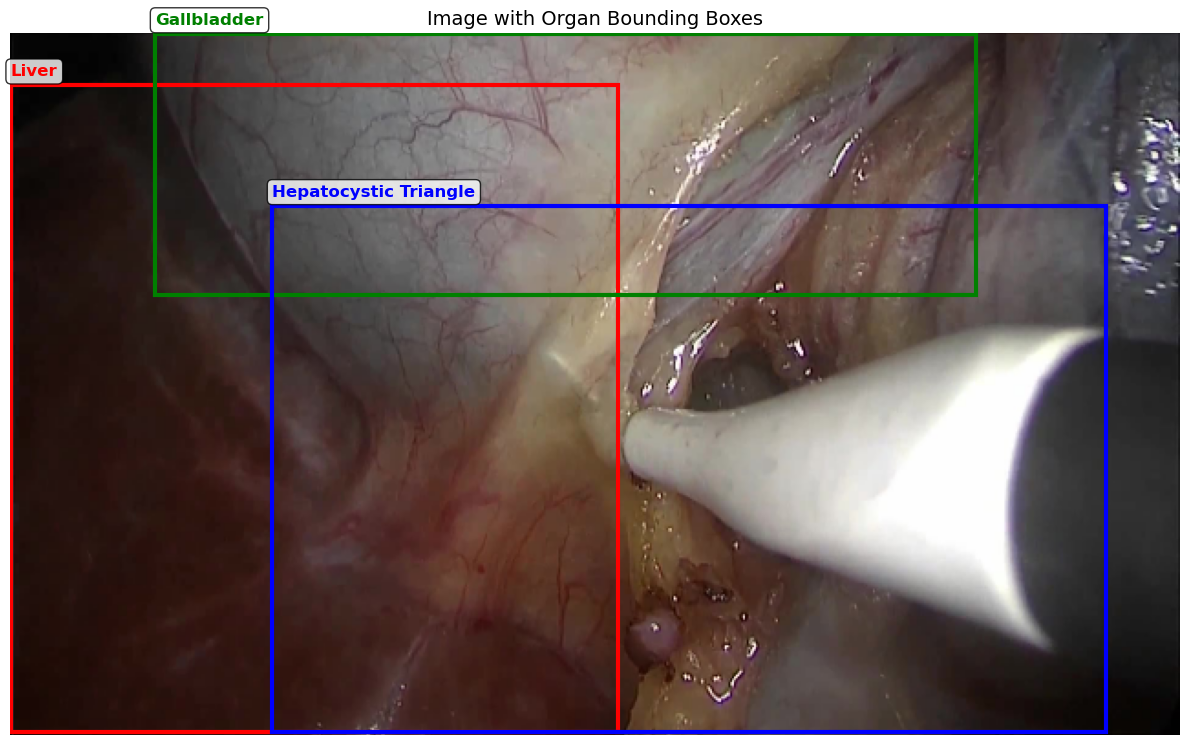

In [7]:
# Visualize bounding boxes on the image
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(image)

# Define colors for each organ class
organ_colors = {
    1: 'red',     # Liver
    2: 'green',   # Gallbladder
    3: 'blue'     # Hepatocystic Triangle
}

# Draw bounding boxes
for class_id, boxes in bboxes.items():
    organ_name = dataset.id2label[class_id]
    color = organ_colors.get(class_id, 'white')
    
    for bbox in boxes:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        
        # Create rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height,
                                linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        ax.text(x_min, y_min - 5, organ_name, 
               color=color, fontsize=12, weight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

ax.set_title('Image with Organ Bounding Boxes', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

## Analyze Dataset Statistics

In [8]:
# Analyze organ distribution across splits
from collections import defaultdict
import torch

split_stats = {}

for split in ['train', 'validation', 'test']:
    print(f"\nAnalyzing {split} split ({dataset.total(split)} examples)...")
    
    organ_counts = defaultdict(int)
    total_examples = dataset.total(split)
    
    # Sample a subset for faster analysis
    sample_size = min(100, total_examples)
    sample_indices = np.random.choice(total_examples, sample_size, replace=False)
    
    for idx in sample_indices:
        example = dataset.get_example(split, int(idx))
        img_t, lab_t = dataset.example_to_tensors(example)
        presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
        
        for i, class_id in enumerate(dataset.label_ids):
            if presence[i] == 1:
                organ_counts[class_id] += 1
    
    # Store and print statistics
    split_stats[split] = organ_counts
    
    print(f"  Organ presence in {sample_size} sampled images:")
    for class_id in dataset.label_ids:
        organ_name = dataset.id2label[class_id]
        count = organ_counts[class_id]
        percentage = (count / sample_size) * 100
        print(f"    {organ_name:25} {count:3d} / {sample_size} ({percentage:5.1f}%)")


Analyzing train split (716 examples)...
  Organ presence in 100 sampled images:
    Liver                     100 / 100 (100.0%)
    Gallbladder               100 / 100 (100.0%)
    Hepatocystic Triangle     100 / 100 (100.0%)

Analyzing validation split (80 examples)...
  Organ presence in 80 sampled images:
    Liver                      80 / 80 (100.0%)
    Gallbladder                80 / 80 (100.0%)
    Hepatocystic Triangle      79 / 80 ( 98.8%)

Analyzing test split (219 examples)...
  Organ presence in 100 sampled images:
    Liver                     100 / 100 (100.0%)
    Gallbladder               100 / 100 (100.0%)
    Hepatocystic Triangle     100 / 100 (100.0%)


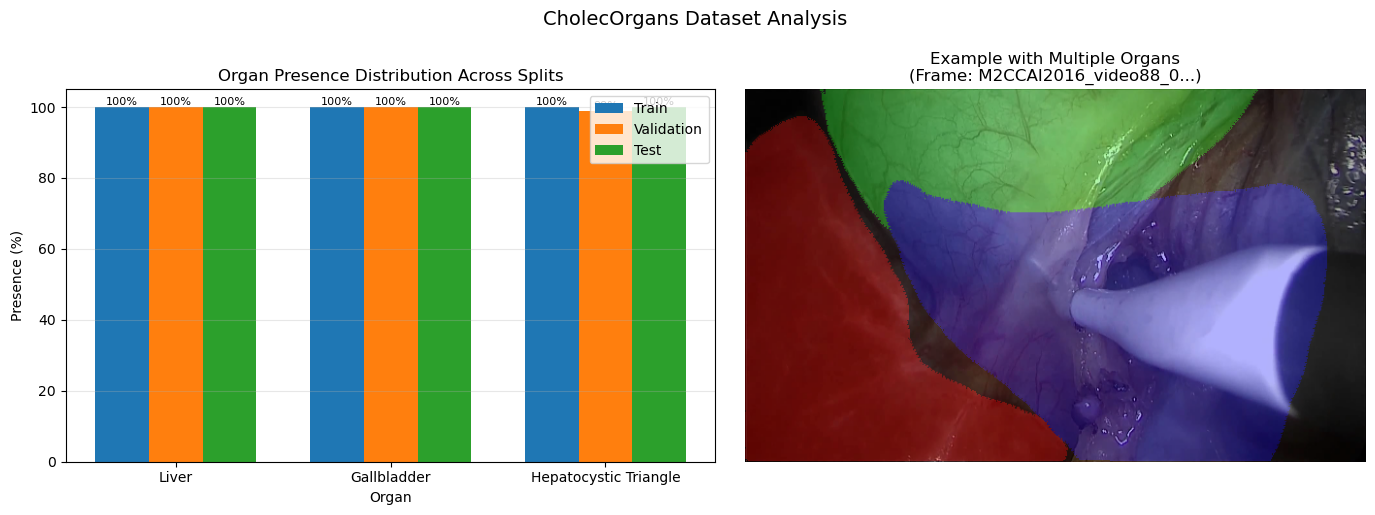

In [9]:
# Visualize organ distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Organ presence across splits
ax = axes[0]
organ_names = [dataset.id2label[cid] for cid in dataset.label_ids]
x = np.arange(len(organ_names))
width = 0.25

for i, split in enumerate(['train', 'validation', 'test']):
    counts = [split_stats[split][cid] for cid in dataset.label_ids]
    sample_size = min(100, dataset.total(split))
    percentages = [(c / sample_size) * 100 for c in counts]
    
    offset = (i - 1) * width
    bars = ax.bar(x + offset, percentages, width, label=split.capitalize())
    
    # Add value labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.0f}%', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Organ')
ax.set_ylabel('Presence (%)')
ax.set_title('Organ Presence Distribution Across Splits')
ax.set_xticks(x)
ax.set_xticklabels(organ_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Example image with overlay
ax = axes[1]

# Find an example with all organs present
for idx in range(min(50, dataset.total('train'))):
    example = dataset.get_example('train', idx)
    img_t, lab_t = dataset.example_to_tensors(example)
    presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
    
    if presence.sum() >= 2:  # At least 2 organs present
        # Create overlay visualization
        image_np = np.array(example['image'])
        label_np = np.array(example['organ_label'])
        
        # Create semi-transparent overlay
        overlay = np.zeros_like(image_np)
        overlay[label_np == 1] = [255, 0, 0]     # Liver - red
        overlay[label_np == 2] = [0, 255, 0]     # Gallbladder - green
        overlay[label_np == 3] = [0, 0, 255]     # Hepatocystic Triangle - blue
        
        # Blend with original image
        alpha = 0.3
        blended = (1 - alpha) * image_np + alpha * overlay
        blended = blended.astype(np.uint8)
        
        ax.imshow(blended)
        ax.set_title(f'Example with Multiple Organs\n(Frame: {example["filename"][:20]}...)')
        ax.axis('off')
        break

plt.suptitle('CholecOrgans Dataset Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Sample Multiple Examples

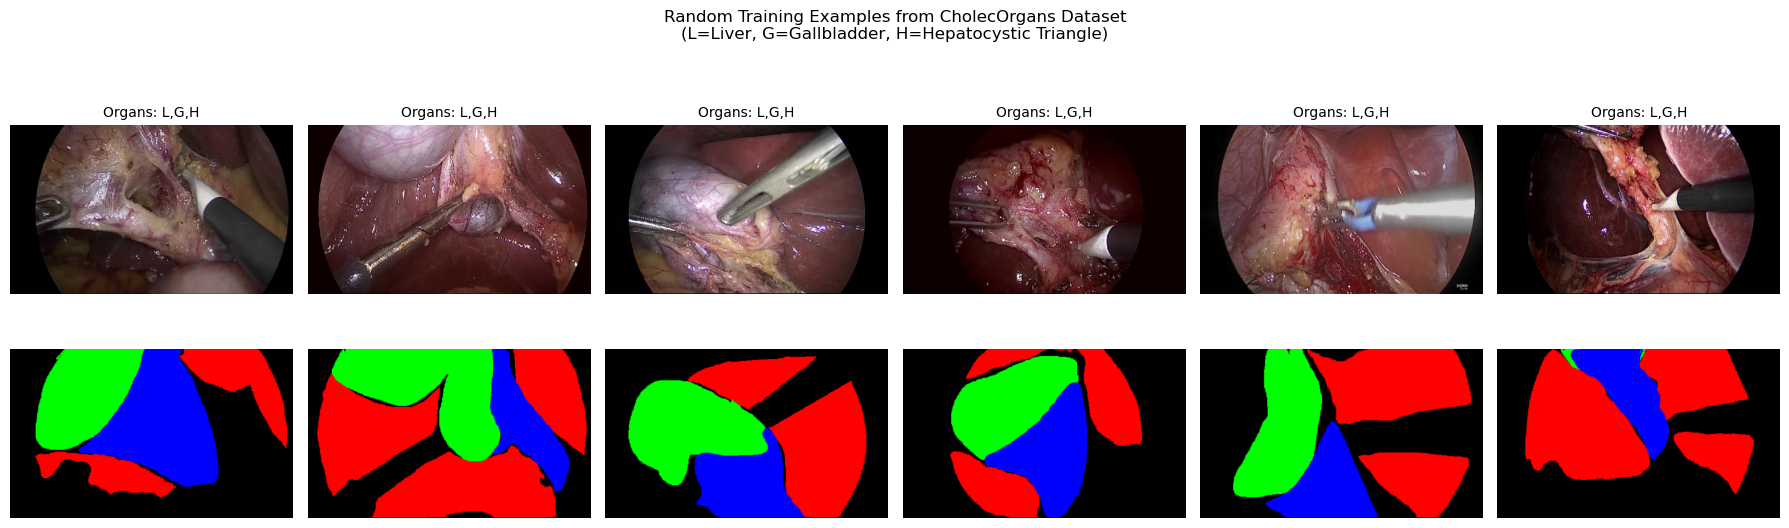

In [10]:
# Display multiple examples in a grid
n_examples = 6
fig, axes = plt.subplots(2, n_examples, figsize=(18, 6))

# Sample random indices
indices = np.random.choice(dataset.total('train'), n_examples, replace=False)

for col, idx in enumerate(indices):
    example = dataset.get_example('train', int(idx))
    img_t, lab_t = dataset.example_to_tensors(example)
    presence = dataset.labels_to_presence_vector(lab_t, min_pixels=50)
    
    # Top row: original images
    axes[0, col].imshow(example['image'])
    axes[0, col].axis('off')
    
    # Get present organs for title
    present_organs = []
    for i, class_id in enumerate(dataset.label_ids):
        if presence[i] == 1:
            present_organs.append(dataset.id2label[class_id][0])  # First letter
    title = ','.join(present_organs) if present_organs else 'None'
    axes[0, col].set_title(f'Organs: {title}', fontsize=10)
    
    # Bottom row: segmentation
    label_np = np.array(example['organ_label'])
    colored_label = np.zeros((*label_np.shape, 3), dtype=np.uint8)
    colored_label[label_np == 1] = [255, 0, 0]     # Liver
    colored_label[label_np == 2] = [0, 255, 0]     # Gallbladder
    colored_label[label_np == 3] = [0, 0, 255]     # Hepatocystic Triangle
    
    axes[1, col].imshow(colored_label)
    axes[1, col].axis('off')

axes[0, 0].set_ylabel('Images', fontsize=12)
axes[1, 0].set_ylabel('Segmentation', fontsize=12)

plt.suptitle('Random Training Examples from CholecOrgans Dataset\n(L=Liver, G=Gallbladder, H=Hepatocystic Triangle)', 
             fontsize=12)
plt.tight_layout()
plt.show()